<a href="https://colab.research.google.com/github/kikiooooo/100dataset/blob/main/BITCOIN_LSTMipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import io
from google.colab import files
import statsmodels.tools.eval_measures

In [28]:
df = pd.read_excel('/content/Bitcoin_comparison.xls', index_col = 0)

In [29]:
df.head()

,BTC-USD,DX=F,ES=F,ETH-USD,GC=F,YM=F,^DJI,^GSPC
Date,,,,,,,,
2017-11-09,7143.580078,94.351997,2584.0,320.884003,1285.599976,23416.0,23461.939453,2584.620117
2017-11-10,6618.140137,94.278000,2579.5,299.252991,1272.400024,23382.0,23422.210938,2582.300049
2017-11-13,6559.490234,94.388000,2582.0,316.716003,1277.300049,23406.0,23439.699219,2584.840088
2017-11-14,6635.750000,93.723000,2578.0,337.631012,1281.500000,23375.0,23409.470703,2578.870117
2017-11-15,7315.540039,93.725998,2565.0,333.356995,1276.500000,23262.0,23271.279297,2564.620117


In [30]:
def Log_Diff(x):
  x = np.log(x/ x.shift(1))
  x = x.dropna()
  return x

df = Log_Diff(df)

In [31]:
df.head()

,BTC-USD,DX=F,ES=F,ETH-USD,GC=F,YM=F,^DJI,^GSPC
Date,,,,,,,,
2017-11-10,-0.076400,-0.000785,-0.001743,-0.069790,-0.010321,-0.001453,-0.001695,-0.000898
2017-11-13,-0.008901,0.001166,0.000969,0.056716,0.003844,0.001026,0.000746,0.000983
2017-11-14,0.011559,-0.007070,-0.001550,0.063948,0.003283,-0.001325,-0.001290,-0.002312
2017-11-15,0.097529,0.000032,-0.005055,-0.012740,-0.003909,-0.004846,-0.005921,-0.005541
2017-11-16,0.073272,0.001365,0.007767,-0.007325,0.000705,0.006940,0.008007,0.008163


In [49]:
test_data = df.tail(301)
test_data = pd.DataFrame(test_data)
test_data.shape
test_data = test_data.drop(['DX=F','GC=F'], axis = 1)
test_data

,BTC-USD,ES=F,ETH-USD,YM=F,^DJI,^GSPC
Date,,,,,,
2022-08-26,-0.064086,-0.034263,-0.117902,-0.030825,-0.030757,-0.034269
2022-08-29,0.001873,-0.006983,0.029572,-0.005844,-0.005729,-0.006689
2022-08-30,-0.025001,-0.010912,-0.018980,-0.009397,-0.009645,-0.011089
2022-08-31,0.012697,-0.007805,0.019397,-0.007677,-0.008861,-0.007848
2022-09-01,0.003852,0.003091,0.020697,0.004146,0.004622,0.002992
...,...,...,...,...,...,...
2023-10-31,0.004783,0.006311,0.003513,0.003568,0.003756,0.006454
2023-11-01,0.021953,0.010333,0.016722,0.006498,0.006685,0.010451
2023-11-02,-0.014182,0.018565,-0.025480,0.016740,0.016823,0.018683


In [33]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# 'BTC-USD' is the target variable, and other columns are explanatory variables
# Separate the target variable and explanatory variables
X = df.drop('BTC-USD', axis=1)
y = df['BTC-USD']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define the proportion of data to use for training
train_proportion = 0.8  # 80% of the data for training

# Calculate the number of samples for training
num_samples = len(df)
num_train_samples = int(train_proportion * num_samples)
num_test_samples = num_samples - num_train_samples

# Split the data into training and testing sets
X_train, X_test = X[:num_train_samples], X[num_train_samples:]
y_train, y_test = y[:num_train_samples], y[num_train_samples:]

# Standardize the data (scaling can help some models, including Random Forest)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform feature selection (e.g., using SelectKBest and f_regression)
# You can choose a different feature selection method and number of top features
num_features_to_select = 5
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Train a model (e.g., Random Forest) using the selected features
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = model.predict(X_test_selected)

# You can then assess the model's performance using evaluation metrics (e.g., MAE, MSE, RMSE)


In [34]:
X_train.shape

(1204, 7)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD

def create_LSTM_model(neurons=32, learn_rate=0.01, momentum=0):
    # Create the model
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
    LSTM_model.add(Dense(1))

    # Use the optimizer you defined
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    LSTM_model.compile(loss='mse', optimizer=optimizer)

    return LSTM_model


In [36]:
# Reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [37]:
LSTMModel = create_LSTM_model(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=330, batch_size=72, verbose=0, shuffle=False)

In [38]:
selected_feature_names

Index(['ES=F', 'ETH-USD', 'YM=F', '^DJI', '^GSPC'], dtype='object')

In [39]:
LSTM_predict = LSTMModel.predict(X_test)
LSTM_predict

10/10 [==============================] - 0s 2ms/step


array([[-0.13329938],
       [ 0.0129786 ],
       [-0.04193583],
       [-0.0026869 ],
       [ 0.02629541],
       [ 0.00387576],
       [ 0.00126606],
       [ 0.02333792],
       [-0.00626905],
       [ 0.06727406],
       [ 0.00079771],
       [-0.02639535],
       [ 0.02127959],
       [-0.10570177],
       [-0.01105914],
       [-0.04363852],
       [-0.05169906],
       [-0.03006225],
       [ 0.03907264],
       [ 0.0546858 ],
       [ 0.02232348],
       [-0.00142927],
       [ 0.00810505],
       [-0.04973684],
       [-0.00700839],
       [-0.01878827],
       [ 0.02784658],
       [ 0.02386237],
       [ 0.03428081],
       [-0.03768021],
       [-0.02834553],
       [ 0.00218857],
       [-0.00512543],
       [ 0.01969792],
       [ 0.00977905],
       [ 0.02807923],
       [-0.02539799],
       [ 0.0100826 ],
       [-0.01054188],
       [ 0.01712387],
       [ 0.02737788],
       [ 0.14735492],
       [ 0.0989887 ],
       [ 0.02265997],
       [ 0.01815891],
       [ 0

In [40]:
X_test

array([[[ 0.71293147, -2.56845979, -1.89368491, ..., -2.28886146,
         -2.27263159, -2.56748885]],

       [[ 0.06159804, -0.54730461,  0.44751388, ..., -0.45133999,
         -0.44059263, -0.52515467]],

       [[-0.12482042, -0.83838641, -0.32326838, ..., -0.71268239,
         -0.72729572, -0.85103635]],

       ...,

       [[-1.78815459,  1.34557718, -0.42645502, ...,  1.20988547,
          1.2100955 ,  1.35365245]],

       [[-2.71727219,  0.65472617,  0.25920522, ...,  0.46062137,
          0.45788625,  0.66252532]],

       [[ 0.42230238,  0.10964442,  0.54838165, ...,  0.03669141,
          0.05291227,  0.09985018]]])

In [50]:
# # Sample time index (replace with your actual time index)
# time_index = np.arange(len(X_test))

# # Flatten the LSTM predictions to make them 1D
# LSTM_predict_flat = LSTM_predict.flatten()

# # Create a DataFrame with the same time index
# predictions_df = pd.DataFrame({'Time Index': time_index, 'LSTM Predictions': LSTM_predict_flat})


# # Print or work with the DataFrame
# print(predictions_df)

# Create a DataFrame with the same index and LSTM predictions
predictions_df = pd.DataFrame({'LSTM Predictions': LSTM_pred}, index=test_data.index)

# Print or work with the DataFrame
print(predictions_df)

            LSTM Predictions
Date                        
2022-08-26         -0.133299
2022-08-29          0.012979
2022-08-30         -0.041936
2022-08-31         -0.002687
2022-09-01          0.026295
...                      ...
2023-10-31         -0.001545
2023-11-01         -0.003005
2023-11-02         -0.020035
2023-11-03          0.047988
2023-11-06          0.014987

[301 rows x 1 columns]


In [51]:
LSTM_predict

array([[-0.13329938],
       [ 0.0129786 ],
       [-0.04193583],
       [-0.0026869 ],
       [ 0.02629541],
       [ 0.00387576],
       [ 0.00126606],
       [ 0.02333792],
       [-0.00626905],
       [ 0.06727406],
       [ 0.00079771],
       [-0.02639535],
       [ 0.02127959],
       [-0.10570177],
       [-0.01105914],
       [-0.04363852],
       [-0.05169906],
       [-0.03006225],
       [ 0.03907264],
       [ 0.0546858 ],
       [ 0.02232348],
       [-0.00142927],
       [ 0.00810505],
       [-0.04973684],
       [-0.00700839],
       [-0.01878827],
       [ 0.02784658],
       [ 0.02386237],
       [ 0.03428081],
       [-0.03768021],
       [-0.02834553],
       [ 0.00218857],
       [-0.00512543],
       [ 0.01969792],
       [ 0.00977905],
       [ 0.02807923],
       [-0.02539799],
       [ 0.0100826 ],
       [-0.01054188],
       [ 0.01712387],
       [ 0.02737788],
       [ 0.14735492],
       [ 0.0989887 ],
       [ 0.02265997],
       [ 0.01815891],
       [ 0

In [52]:
LSTM_pred=list(LSTM_predict.reshape(-1))
LSTM_pred

[-0.13329938,
 0.012978604,
 -0.04193583,
 -0.0026869047,
 0.026295407,
 0.003875764,
 0.0012660567,
 0.023337921,
 -0.006269045,
 0.067274064,
 0.0007977057,
 -0.026395345,
 0.021279586,
 -0.10570177,
 -0.011059135,
 -0.04363852,
 -0.05169906,
 -0.030062249,
 0.03907264,
 0.0546858,
 0.02232348,
 -0.0014292728,
 0.008105049,
 -0.049736835,
 -0.007008387,
 -0.018788269,
 0.027846584,
 0.023862375,
 0.034280807,
 -0.03768021,
 -0.02834553,
 0.002188569,
 -0.005125433,
 0.019697921,
 0.009779049,
 0.028079232,
 -0.02539799,
 0.010082597,
 -0.010541877,
 0.017123869,
 0.02737788,
 0.14735492,
 0.098988704,
 0.022659967,
 0.01815891,
 0.021022385,
 0.0056763683,
 -0.09673189,
 0.059702277,
 0.10869237,
 -0.03164559,
 0.008651117,
 -0.08983243,
 0.12420017,
 0.0165688,
 -0.0069703404,
 0.001762623,
 -0.040930927,
 -0.0074315555,
 -0.00085692666,
 -0.007967943,
 0.03365778,
 0.092921756,
 0.010035271,
 -0.010495396,
 0.022424513,
 0.06398516,
 -0.021533491,
 0.002383465,
 -0.01000379,
 0.001

In [53]:
y_pred

array([-8.44911205e-02,  1.46590683e-02, -1.16566649e-02,  9.39922688e-03,
        1.47367888e-02,  1.71720800e-02,  2.65073783e-03,  2.75589726e-02,
       -3.40184185e-03,  2.86962570e-02,  3.00940674e-03, -6.37378404e-02,
        1.05209285e-02, -5.78018883e-02, -1.99706616e-02, -2.73114156e-02,
       -3.34199016e-02, -9.62505206e-03,  2.95953605e-02, -5.16752306e-03,
        1.13126532e-02,  1.09358459e-02, -3.30636759e-03, -4.54336833e-03,
        3.18833487e-03, -1.31825008e-03,  3.13388765e-02, -2.94362872e-03,
        7.55931695e-03, -5.87370412e-03, -2.08523456e-02, -1.56324561e-02,
        2.34774062e-02,  8.40141382e-03,  1.44049053e-02,  1.89420718e-02,
       -3.30712102e-03, -7.96923670e-03,  5.38808833e-03,  1.84208863e-02,
        1.26872383e-02,  3.99662181e-02,  4.03091345e-02, -1.55324669e-02,
        3.10352282e-02,  3.08051224e-02,  2.54475091e-03, -2.76855724e-02,
        1.46440634e-02,  4.53443644e-02, -2.69580306e-02, -1.04615288e-01,
       -1.43157248e-01,  

In [54]:
statsmodels.tools.eval_measures.meanabs(y_pred, y_test)

0.013234649337884666

In [55]:
statsmodels.tools.eval_measures.meanabs(LSTM_pred, y_test)

0.019679793911782335

In [56]:
y_test

Date
2022-08-26   -0.064086
2022-08-29    0.001873
2022-08-30   -0.025001
2022-08-31    0.012697
2022-09-01    0.003852
                ...   
2023-10-31    0.004783
2023-11-01    0.021953
2023-11-02   -0.014182
2023-11-03   -0.005911
2023-11-06    0.008744
Name: BTC-USD, Length: 301, dtype: float64

In [57]:
predictions_df

,LSTM Predictions
Date,
2022-08-26,-0.133299
2022-08-29,0.012979
2022-08-30,-0.041936
2022-08-31,-0.002687
2022-09-01,0.026295
...,...
2023-10-31,-0.001545
2023-11-01,-0.003005
2023-11-02,-0.020035


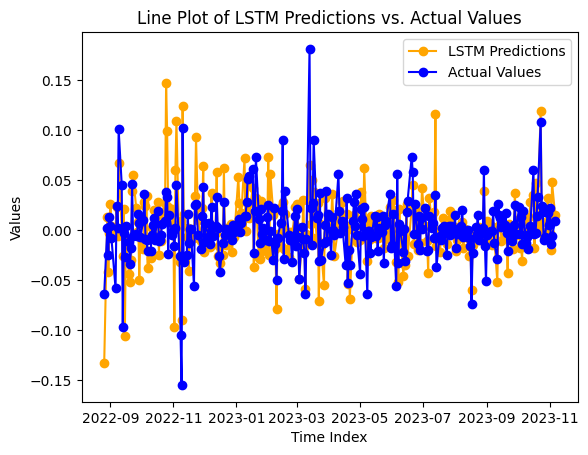

In [58]:
time_index = y_test.index
# Create a line plot for LSTM predictions (orange color)
plt.plot(time_index, LSTM_pred, color='orange', marker='o', label='LSTM Predictions')

# Create a line plot for actual values (blue color)
plt.plot(time_index, y_test, color='blue', marker='o', label='Actual Values')

# Add labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Line Plot of LSTM Predictions vs. Actual Values')

# Display the legend
plt.legend()

# Show the plot
plt.show()



In [63]:
num_features = X_train.shape[1]

In [75]:
time_step = 12
pred_months = 36  # 3 years

# Initialize the input data
x_input = y_test[-time_step:].to_numpy().reshape(1, -1)  # Use the last "time_step" months of data

temp_input = list(x_input[0])
lst_output = []

n_steps = time_step
i = 0

x_input.shape

(1, 12)

In [76]:
x_input = x_input.reshape(1, time_step, num_features)

In [77]:
while i < pred_months:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)

  # Modify num_features to match your data
        yhat = LSTMModel.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = LSTMModel.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i = i + 1

# Perform post-processing as before

# Create a time index for the next 36 months
time_index = pd.date_range(start=test_data.index[-1], periods=pred_months + 1, freq='M')

# Inverse transform the predictions and create a DataFrame
next_predicted_values = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten()
new_pred_plot = pd.DataFrame({'Predicted Close': next_predicted_values}, index=time_index)

# Plotting and customization as before
names = cycle(['Predicted Close Price'])
fig = px.line(new_pred_plot, x=new_pred_plot.index, y=new_pred_plot['Predicted Close'],
              labels={'value': 'Bitcoin Price', 'index': 'Timestamp'})
fig.update_layout(title_text='Bitcoin Price Prediction for the Next 36 Months',
                  plot_bgcolor='white', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

InvalidArgumentError: ignored

In [ ]:
plt.figure(figsize=(16,8))
plt.title('LSTMModel')
plt.xlabel('Date')
plt.ylabel('Bit Coin')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

ValueError: ignored

In [ ]:
time_step = 12
x_input=test_data[len(test_data)-time_step:].to_numpy()
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
from numpy import array
lst_output=[]
n_steps=time_step
i=0
pred_days = 60
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = LSTMModel.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = LSTMModel.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1
temp_mat = np.empty(pred_days+1)
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]
next_predicted_days_value = temp_mat
next_predicted_days_value = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({
    'Predicted Close':next_predicted_days_value
})
names = cycle(['Predicted next 60 days close price'])
fig = px.line(new_pred_plot,x=new_pred_plot.index, y= new_pred_plot['Predicted Close'],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Next 60 days Closing price prediction',
                  plot_bgcolor='white',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

TypeError: ignored